In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random
from tensorflow.keras.applications import VGG16

import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

2025-05-15 10:18:26.178992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-15 10:18:26.693634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-15 10:18:26.833459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Dataset Preparation

In [4]:
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [5]:
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")

Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.
Removed the existing folder: aircraft_damage_dataset_v1


/tmp/ipykernel_1173/932681649.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall()  # This will extract to the current directory


Extracted aircraft_damage_dataset_v1.tar successfully.


In [6]:
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

## Data Preprocessing

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_rows, img_cols),  
                                                    batch_size=batch_size, 
                                                    seed = seed_value, 
                                                    class_mode='binary', 
                                                    shuffle=True)

Found 300 images belonging to 2 classes.


In [9]:
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='binary', shuffle=False)

Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Model Definition

In [10]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [11]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

for layer in base_model.layers:
    layer.trainable = False

In [12]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In [14]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=n_epochs)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 223s 22s/step - accuracy: 0.5192 - loss: 0.7190 - val_accuracy: 0.6042 - val_loss: 0.6338
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 215s 22s/step - accuracy: 0.7010 - loss: 0.5582 - val_accuracy: 0.6979 - val_loss: 0.5823
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 216s 23s/step - accuracy: 0.7879 - loss: 0.4845 - val_accuracy: 0.7188 - val_loss: 0.5509
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 228s 23s/step - accuracy: 0.8226 - loss: 0.3891 - val_accuracy: 0.6667 - val_loss: 0.6491
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 219s 22s/step - accuracy: 0.8531 - loss: 0.3440 - val_accuracy: 0.6979 - val_loss: 0.5090


In [15]:
train_history = model.history.history

## Visualizing Training Results

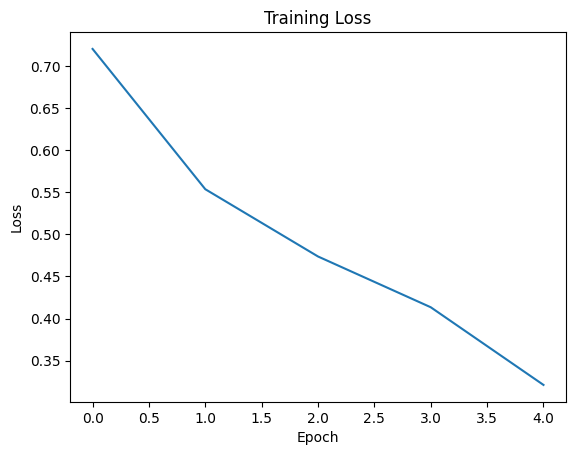

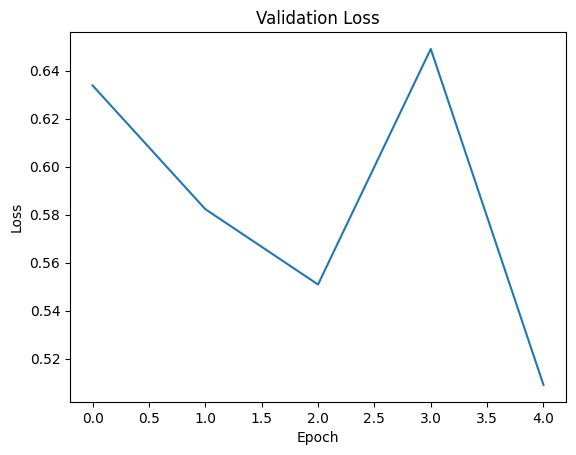

In [16]:
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

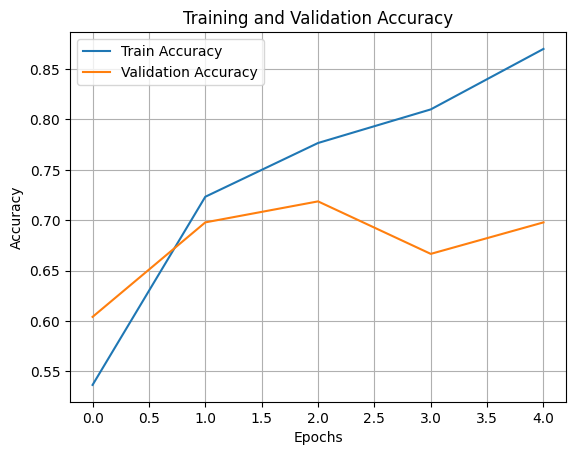

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.6875 - loss: 0.7393
Test Loss: 0.7393
Test Accuracy: 0.6875


## Visualizing Predictions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)

## Visualizing the results

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


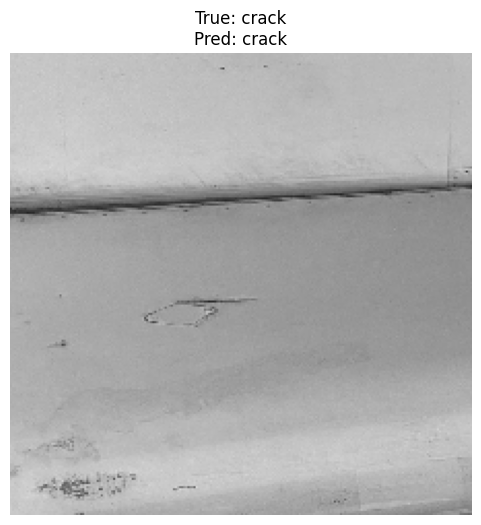

In [20]:
test_model_on_image(test_generator, model, index_to_plot=1)

# Image Captioning and Summarization using BLIP

## Loading BLIP Model

In [21]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/opt/conda/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"

In [23]:
def generate_text(image_path_str, task_str):
    """
    Generates text (caption or summary) for a given image using BLIP.

    Args:
        image_path_str (str): The file path to the image.
        task_str (str): Either 'caption' or 'summary'.

    Returns:
        str: The generated text.
    """
    # Load BLIP processor and model
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Instantiate the custom Keras layer
    blip_layer = BlipCaptionSummaryLayer(processor, model)

    # Convert inputs to tf.constant (as required by TensorFlow)
    image_path_tensor = tf.constant(image_path_str)
    task_tensor = tf.constant(task_str)

    # Call the custom layer to get the result
    result_tensor = blip_layer(image_path_tensor, task_tensor)

    # Convert TensorFlow tensor result to a Python string
    return result_tensor.numpy().decode("utf-8")

In [24]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

caption = generate_text(image_path, "caption")
print("Caption:", caption)

summary = generate_text(image_path, "summary")
print("Summary:", summary)

/opt/conda/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


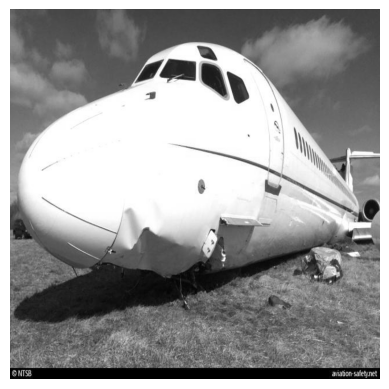

In [25]:
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
image_path = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
caption_tensor = generate_text(image_path, "caption")
print("Caption:", caption_tensor)

Caption: this is a picture of a plane that was sitting on the ground in a field


In [ ]:
image_path = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
summary_tensor = generate_text(image_path, "summary")
print("Summary:", summary_tensor)